# Tutorial 2: T Cell State Classification

This tutorial demonstrates how to fine-tune TCRfoundation for T cell state classification tasks:
- Disease classification
- Tissue classification
- Cell subtype classification

## Overview
- Load pretrained foundation model
- Fine-tune for multiple classification tasks
- Evaluate performance across different modalities
- Extract embeddings and predictions

## 1. Setup and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import os
import torch
import numpy as np
import scanpy as sc
import tcrfoundation as tcrf
from tcrfoundation.finetune.utils import (
    build_results_dataframe, 
    plot_all_metrics_bubble_chart, 
    compute_umaps, 
    create_combined_visualization
)

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Configuration

In [7]:
# Paths
checkpoint_path = "../TCR_foundation_model/foundation_model_best.pt"
results_dir = "../results/classification"
model_output_dir = "../fine_tune_models/classification"

# Training parameters
num_epochs = 2 # Just for demonstration. When training from scratch, please set the epoachs as 50.
batch_size = 512

# Create directories
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print(f"Checkpoint: {checkpoint_path}")
print(f"Results will be saved to: {results_dir}")
print(f"Models will be saved to: {model_output_dir}")

Checkpoint: ../TCR_foundation_model/foundation_model_best.pt
Results will be saved to: ../results/classification
Models will be saved to: ../fine_tune_models/classification


## 3. Load Data

In [8]:
# Load fine-tuning data
adata = sc.read("../data/adata_finetune.h5ad")
print(f"Dataset size: {adata.n_obs} cells, {adata.n_vars} genes")

# Define classification tasks
label_columns = ["Disease Metatype", "Tissue Metatype", "cell_subtype_v3"]

print("\nClassification tasks:")
for col in label_columns:
    n_classes = adata.obs[col].nunique()
    print(f"  - {col}: {n_classes} classes")

Dataset size: 444979 cells, 3000 genes

Classification tasks:
  - Disease Metatype: 6 classes
  - Tissue Metatype: 8 classes
  - cell_subtype_v3: 15 classes


## 4. Train Classifiers

We'll train classifiers for three tasks sequentially, accumulating embeddings and predictions.

In [9]:
# Initialize results dictionary
results = {}
adata_with_all_tasks = adata.copy()

### 4.1 Disease Classification

In [10]:
print("\n" + "="*60)
print("Training Disease Classifier")
print("="*60)

disease_results, adata_disease = tcrf.finetune.classification.train_classifier(
    adata_with_all_tasks, 
    "Disease Metatype", 
    checkpoint_path, 
    num_epochs=num_epochs, 
    batch_size=batch_size
)

results["Disease Metatype"] = disease_results
adata_with_all_tasks = adata_disease.copy()
print("\nDisease classifier training complete")


Training Disease Classifier
Number of classes: 6, Classes: ['Autoimmune disease', 'COVID-19', 'Infection', 'Inflammation', 'Organoid', 'Solid tumor']
Loaded model with max_length: 30

==================== Training Disease Metatype classifier: rna_only ====================
Loaded model with max_length: 30


Mode rna_only Epoch 1/2: Train Loss = 0.3145 | Val Loss = 0.2432 | Val Acc = 0.9117
--> Best model saved with Val Acc = 0.9117


Mode rna_only Epoch 2/2: Train Loss = 0.2364 | Val Loss = 0.2328 | Val Acc = 0.9139
--> Best model saved with Val Acc = 0.9139

==================== Training Disease Metatype classifier: tcr_only ====================
Loaded model with max_length: 30


Mode tcr_only Epoch 1/2: Train Loss = 1.1875 | Val Loss = 1.1548 | Val Acc = 0.6101
--> Best model saved with Val Acc = 0.6101


Mode tcr_only Epoch 2/2: Train Loss = 1.1439 | Val Loss = 1.1251 | Val Acc = 0.6185
--> Best model saved with Val Acc = 0.6185

==================== Training Disease Metatype classifier: tcra_only ====================
Loaded model with max_length: 30


Mode tcra_only Epoch 1/2: Train Loss = 1.2023 | Val Loss = 1.1764 | Val Acc = 0.6017
--> Best model saved with Val Acc = 0.6017


Mode tcra_only Epoch 2/2: Train Loss = 1.1622 | Val Loss = 1.1465 | Val Acc = 0.6118
--> Best model saved with Val Acc = 0.6118

==================== Training Disease Metatype classifier: tcrb_only ====================
Loaded model with max_length: 30


Mode tcrb_only Epoch 1/2: Train Loss = 1.2038 | Val Loss = 1.1724 | Val Acc = 0.6062
--> Best model saved with Val Acc = 0.6062


Mode tcrb_only Epoch 2/2: Train Loss = 1.1672 | Val Loss = 1.1528 | Val Acc = 0.6128
--> Best model saved with Val Acc = 0.6128

==================== Training Disease Metatype classifier: rna_tcr ====================
Loaded model with max_length: 30


Mode rna_tcr Epoch 1/2: Train Loss = 0.2383 | Val Loss = 0.1137 | Val Acc = 0.9602
--> Best model saved with Val Acc = 0.9602


Mode rna_tcr Epoch 2/2: Train Loss = 0.0935 | Val Loss = 0.0762 | Val Acc = 0.9735
--> Best model saved with Val Acc = 0.9735

=== Extracting embeddings and predictions for Disease Metatype ===
Loaded model with max_length: 30

Extracting embeddings and predictions for rna_only modality...


Processing rna_only: 100%|████████████████████████████████| 435/435 [00:21<00:00, 20.71it/s]


Stored embedding in adata.obsm['X_disease_metatype_rna_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['disease_metatype_rna_only_pred']

Extracting embeddings and predictions for tcr_only modality...


Processing tcr_only: 100%|████████████████████████████████| 435/435 [00:22<00:00, 19.58it/s]


Stored embedding in adata.obsm['X_disease_metatype_tcr_only_emb'] with shape (444979, 256)
Stored predictions in adata.obs['disease_metatype_tcr_only_pred']

Extracting embeddings and predictions for tcra_only modality...


Processing tcra_only: 100%|███████████████████████████████| 435/435 [00:21<00:00, 20.30it/s]


Stored embedding in adata.obsm['X_disease_metatype_tcra_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['disease_metatype_tcra_only_pred']

Extracting embeddings and predictions for tcrb_only modality...


Processing tcrb_only: 100%|███████████████████████████████| 435/435 [00:21<00:00, 19.81it/s]


Stored embedding in adata.obsm['X_disease_metatype_tcrb_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['disease_metatype_tcrb_only_pred']

Extracting embeddings and predictions for rna_tcr modality...


Processing rna_tcr: 100%|█████████████████████████████████| 435/435 [00:22<00:00, 19.67it/s]


Stored embedding in adata.obsm['X_disease_metatype_rna_tcr_emb'] with shape (444979, 256)
Stored predictions in adata.obs['disease_metatype_rna_tcr_pred']

✓ Disease classifier training complete


### 4.2 Tissue Classification

In [11]:
print("\n" + "="*60)
print("Training Tissue Classifier")
print("="*60)

tissue_results, adata_tissue = tcrf.finetune.classification.train_classifier(
    adata_with_all_tasks, 
    "Tissue Metatype", 
    checkpoint_path, 
    num_epochs=num_epochs, 
    batch_size=batch_size
)

results["Tissue Metatype"] = tissue_results
adata_with_all_tasks = adata_tissue.copy()
print("\n Tissue classifier training complete")


Training Tissue Classifier
Number of classes: 8, Classes: ['BALF', 'Lymph Node', 'Normal Tissue', 'Organoid', 'PBMC', 'Synovial fluid', 'TIL', 'Tumor Tissue']
Loaded model with max_length: 30

==================== Training Tissue Metatype classifier: rna_only ====================
Loaded model with max_length: 30


Mode rna_only Epoch 1/2: Train Loss = 0.4164 | Val Loss = 0.3304 | Val Acc = 0.8779
--> Best model saved with Val Acc = 0.8779


Mode rna_only Epoch 2/2: Train Loss = 0.3111 | Val Loss = 0.3068 | Val Acc = 0.8875
--> Best model saved with Val Acc = 0.8875



==================== Training Tissue Metatype classifier: tcr_only ====================
Loaded model with max_length: 30


Mode tcr_only Epoch 1/2: Train Loss = 1.4975 | Val Loss = 1.4529 | Val Acc = 0.4468
--> Best model saved with Val Acc = 0.4468


Mode tcr_only Epoch 2/2: Train Loss = 1.4471 | Val Loss = 1.4144 | Val Acc = 0.4697
--> Best model saved with Val Acc = 0.4697

==================== Training Tissue Metatype classifier: tcra_only ====================
Loaded model with max_length: 30


Mode tcra_only Epoch 1/2: Train Loss = 1.5079 | Val Loss = 1.4708 | Val Acc = 0.4446
--> Best model saved with Val Acc = 0.4446


Mode tcra_only Epoch 2/2: Train Loss = 1.4637 | Val Loss = 1.4320 | Val Acc = 0.4688
--> Best model saved with Val Acc = 0.4688

==================== Training Tissue Metatype classifier: tcrb_only ====================
Loaded model with max_length: 30


Mode tcrb_only Epoch 1/2: Train Loss = 1.5097 | Val Loss = 1.4770 | Val Acc = 0.4447
--> Best model saved with Val Acc = 0.4447


Mode tcrb_only Epoch 2/2: Train Loss = 1.4716 | Val Loss = 1.4417 | Val Acc = 0.4591
--> Best model saved with Val Acc = 0.4591

==================== Training Tissue Metatype classifier: rna_tcr ====================
Loaded model with max_length: 30


Mode rna_tcr Epoch 1/2: Train Loss = 0.3647 | Val Loss = 0.2418 | Val Acc = 0.9082
--> Best model saved with Val Acc = 0.9082


Mode rna_tcr Epoch 2/2: Train Loss = 0.2181 | Val Loss = 0.1992 | Val Acc = 0.9245
--> Best model saved with Val Acc = 0.9245



=== Extracting embeddings and predictions for Tissue Metatype ===
Loaded model with max_length: 30

Extracting embeddings and predictions for rna_only modality...


Processing rna_only: 100%|████████████████████████████████| 435/435 [00:20<00:00, 20.83it/s]


Stored embedding in adata.obsm['X_tissue_metatype_rna_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['tissue_metatype_rna_only_pred']

Extracting embeddings and predictions for tcr_only modality...


Processing tcr_only: 100%|████████████████████████████████| 435/435 [00:22<00:00, 19.72it/s]


Stored embedding in adata.obsm['X_tissue_metatype_tcr_only_emb'] with shape (444979, 256)
Stored predictions in adata.obs['tissue_metatype_tcr_only_pred']

Extracting embeddings and predictions for tcra_only modality...


Processing tcra_only: 100%|███████████████████████████████| 435/435 [00:21<00:00, 19.99it/s]


Stored embedding in adata.obsm['X_tissue_metatype_tcra_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['tissue_metatype_tcra_only_pred']

Extracting embeddings and predictions for tcrb_only modality...


Processing tcrb_only: 100%|███████████████████████████████| 435/435 [00:21<00:00, 20.12it/s]


Stored embedding in adata.obsm['X_tissue_metatype_tcrb_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['tissue_metatype_tcrb_only_pred']

Extracting embeddings and predictions for rna_tcr modality...


Processing rna_tcr: 100%|█████████████████████████████████| 435/435 [00:22<00:00, 19.72it/s]


Stored embedding in adata.obsm['X_tissue_metatype_rna_tcr_emb'] with shape (444979, 256)
Stored predictions in adata.obs['tissue_metatype_rna_tcr_pred']

✓ Tissue classifier training complete


### 4.3 Cell Subtype Classification

In [12]:
print("\n" + "="*60)
print("Training Cell Subtype Classifier")
print("="*60)

cell_results, adata_cell = tcrf.finetune.classification.train_classifier(
    adata_with_all_tasks, 
    "cell_subtype_v3", 
    checkpoint_path, 
    num_epochs=num_epochs, 
    batch_size=batch_size
)

results["cell_subtype_v3"] = cell_results
adata_with_all_tasks = adata_cell.copy()
print("\nCell subtype classifier training complete")


Training Cell Subtype Classifier
Number of classes: 15, Classes: ['CD4+ Cycling', 'CD4+ IFNG+ T', 'CD4+ TFH', 'CD4+ Tm', 'CD4+ Tn', 'CD4+ Treg', 'CD8+ Cycling', 'CD8+ ILTCK', 'CD8+ MAIT', 'CD8+ Teff', 'CD8+ Temra', 'CD8+ Tex', 'CD8+ Tm', 'CD8+ Tn', 'CD8+ Tpex']
Loaded model with max_length: 30

==================== Training cell_subtype_v3 classifier: rna_only ====================
Loaded model with max_length: 30


Mode rna_only Epoch 1/2: Train Loss = 0.5347 | Val Loss = 0.4243 | Val Acc = 0.8498
--> Best model saved with Val Acc = 0.8498


Mode rna_only Epoch 2/2: Train Loss = 0.4043 | Val Loss = 0.3999 | Val Acc = 0.8548
--> Best model saved with Val Acc = 0.8548



==================== Training cell_subtype_v3 classifier: tcr_only ====================
Loaded model with max_length: 30


Mode tcr_only Epoch 1/2: Train Loss = 2.0523 | Val Loss = 1.9897 | Val Acc = 0.3519
--> Best model saved with Val Acc = 0.3519


Mode tcr_only Epoch 2/2: Train Loss = 1.9757 | Val Loss = 1.9429 | Val Acc = 0.3709
--> Best model saved with Val Acc = 0.3709

==================== Training cell_subtype_v3 classifier: tcra_only ====================
Loaded model with max_length: 30


Mode tcra_only Epoch 1/2: Train Loss = 2.0906 | Val Loss = 2.0348 | Val Acc = 0.3334
--> Best model saved with Val Acc = 0.3334


Mode tcra_only Epoch 2/2: Train Loss = 2.0148 | Val Loss = 1.9874 | Val Acc = 0.3552
--> Best model saved with Val Acc = 0.3552



==================== Training cell_subtype_v3 classifier: tcrb_only ====================
Loaded model with max_length: 30


Mode tcrb_only Epoch 1/2: Train Loss = 2.0966 | Val Loss = 2.0413 | Val Acc = 0.3257
--> Best model saved with Val Acc = 0.3257


Mode tcrb_only Epoch 2/2: Train Loss = 2.0329 | Val Loss = 2.0033 | Val Acc = 0.3440
--> Best model saved with Val Acc = 0.3440



==================== Training cell_subtype_v3 classifier: rna_tcr ====================
Loaded model with max_length: 30


Mode rna_tcr Epoch 1/2: Train Loss = 0.4690 | Val Loss = 0.3406 | Val Acc = 0.8759
--> Best model saved with Val Acc = 0.8759


Mode rna_tcr Epoch 2/2: Train Loss = 0.3340 | Val Loss = 0.3176 | Val Acc = 0.8828
--> Best model saved with Val Acc = 0.8828



=== Extracting embeddings and predictions for cell_subtype_v3 ===
Loaded model with max_length: 30

Extracting embeddings and predictions for rna_only modality...


Processing rna_only: 100%|████████████████████████████████| 435/435 [00:21<00:00, 20.70it/s]


Stored embedding in adata.obsm['X_cell_subtype_v3_rna_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['cell_subtype_v3_rna_only_pred']

Extracting embeddings and predictions for tcr_only modality...


Processing tcr_only: 100%|████████████████████████████████| 435/435 [00:22<00:00, 19.47it/s]


Stored embedding in adata.obsm['X_cell_subtype_v3_tcr_only_emb'] with shape (444979, 256)
Stored predictions in adata.obs['cell_subtype_v3_tcr_only_pred']

Extracting embeddings and predictions for tcra_only modality...


Processing tcra_only: 100%|███████████████████████████████| 435/435 [00:22<00:00, 19.68it/s]


Stored embedding in adata.obsm['X_cell_subtype_v3_tcra_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['cell_subtype_v3_tcra_only_pred']

Extracting embeddings and predictions for tcrb_only modality...


Processing tcrb_only: 100%|███████████████████████████████| 435/435 [00:21<00:00, 20.10it/s]


Stored embedding in adata.obsm['X_cell_subtype_v3_tcrb_only_emb'] with shape (444979, 128)
Stored predictions in adata.obs['cell_subtype_v3_tcrb_only_pred']

Extracting embeddings and predictions for rna_tcr modality...


Processing rna_tcr: 100%|█████████████████████████████████| 435/435 [00:22<00:00, 19.71it/s]


Stored embedding in adata.obsm['X_cell_subtype_v3_rna_tcr_emb'] with shape (444979, 256)
Stored predictions in adata.obs['cell_subtype_v3_rna_tcr_pred']

✓ Cell subtype classifier training complete


## 5. Save Results

In [13]:
# Save the final adata with all embeddings and predictions
output_path = f"{results_dir}/adata_with_all_tasks_embeddings_predictions.h5ad"
adata_with_all_tasks.write(output_path)
print(f"Saved adata to: {output_path}")

✓ Saved adata to: ../results/classification/adata_with_all_tasks_embeddings_predictions.h5ad


## 6. Performance Summary

In [15]:
print("\n" + "="*60)
print("Classification Performance Summary")
print("="*60)

for task, task_results in results.items():
    print(f"\n{task}:")
    print("-" * 60)
    for mode, metrics in task_results.items():
        test_acc, test_f1_macro, test_f1_weighted = metrics['test']
        print(f"  {mode:15s}: Acc={test_acc:.3f}, F1-macro={test_f1_macro:.3f}, F1-weighted={test_f1_weighted:.3f}")


Classification Performance Summary

Disease Metatype:
------------------------------------------------------------
  rna_only       : Acc=0.914, F1-macro=0.911, F1-weighted=0.914
  tcr_only       : Acc=0.618, F1-macro=0.258, F1-weighted=0.509
  tcra_only      : Acc=0.612, F1-macro=0.242, F1-weighted=0.498
  tcrb_only      : Acc=0.612, F1-macro=0.222, F1-weighted=0.496
  rna_tcr        : Acc=0.973, F1-macro=0.969, F1-weighted=0.973

Tissue Metatype:
------------------------------------------------------------
  rna_only       : Acc=0.887, F1-macro=0.819, F1-weighted=0.884
  tcr_only       : Acc=0.471, F1-macro=0.187, F1-weighted=0.385
  tcra_only      : Acc=0.465, F1-macro=0.180, F1-weighted=0.376
  tcrb_only      : Acc=0.458, F1-macro=0.162, F1-weighted=0.363
  rna_tcr        : Acc=0.924, F1-macro=0.880, F1-weighted=0.924

cell_subtype_v3:
------------------------------------------------------------
  rna_only       : Acc=0.854, F1-macro=0.773, F1-weighted=0.851
  tcr_only       : Acc

## 8. Visualize Results

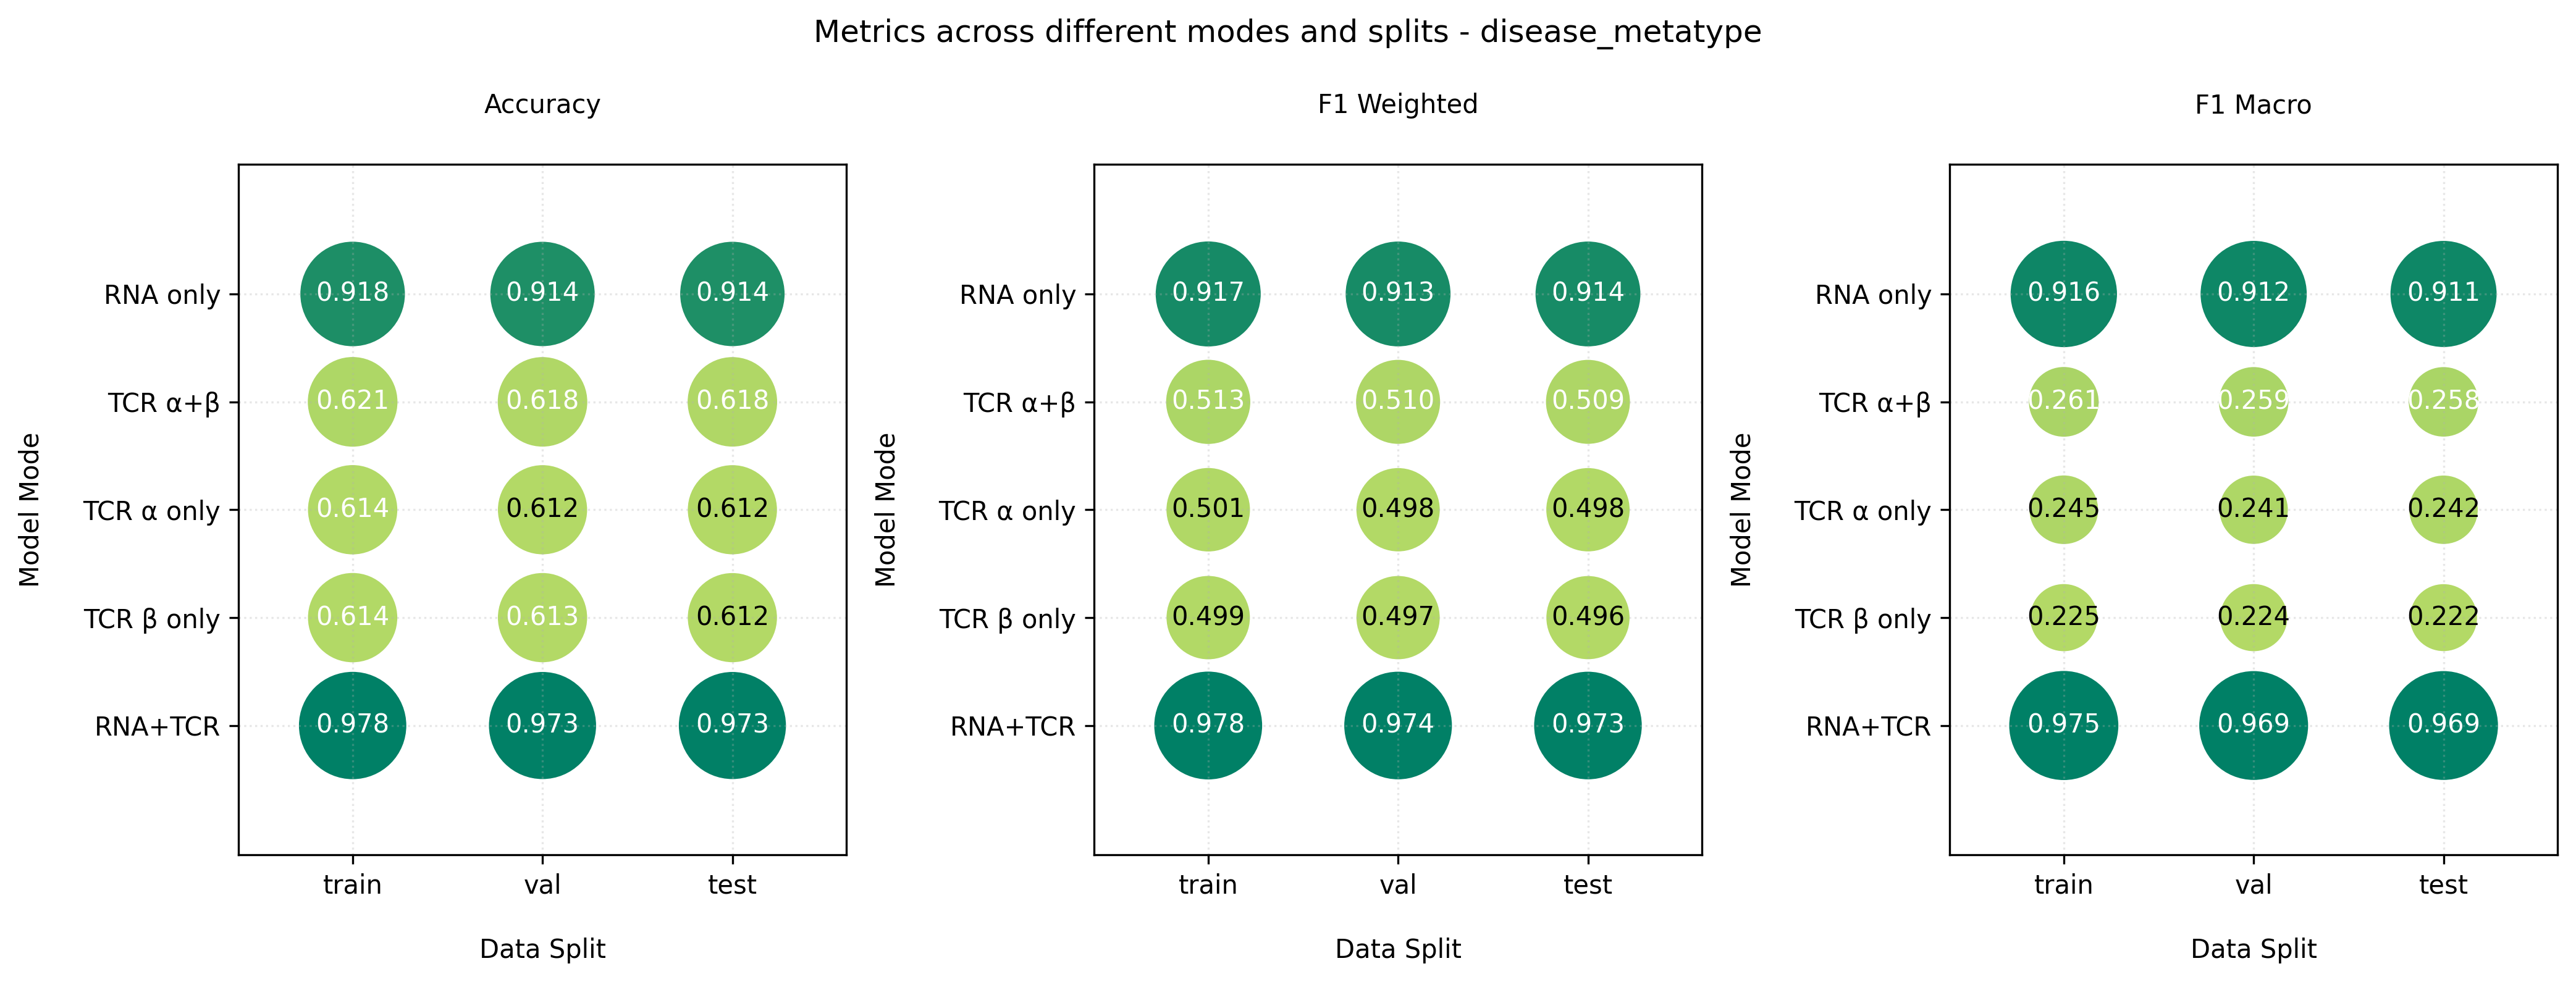

✓ Saved results and plots for Disease Metatype


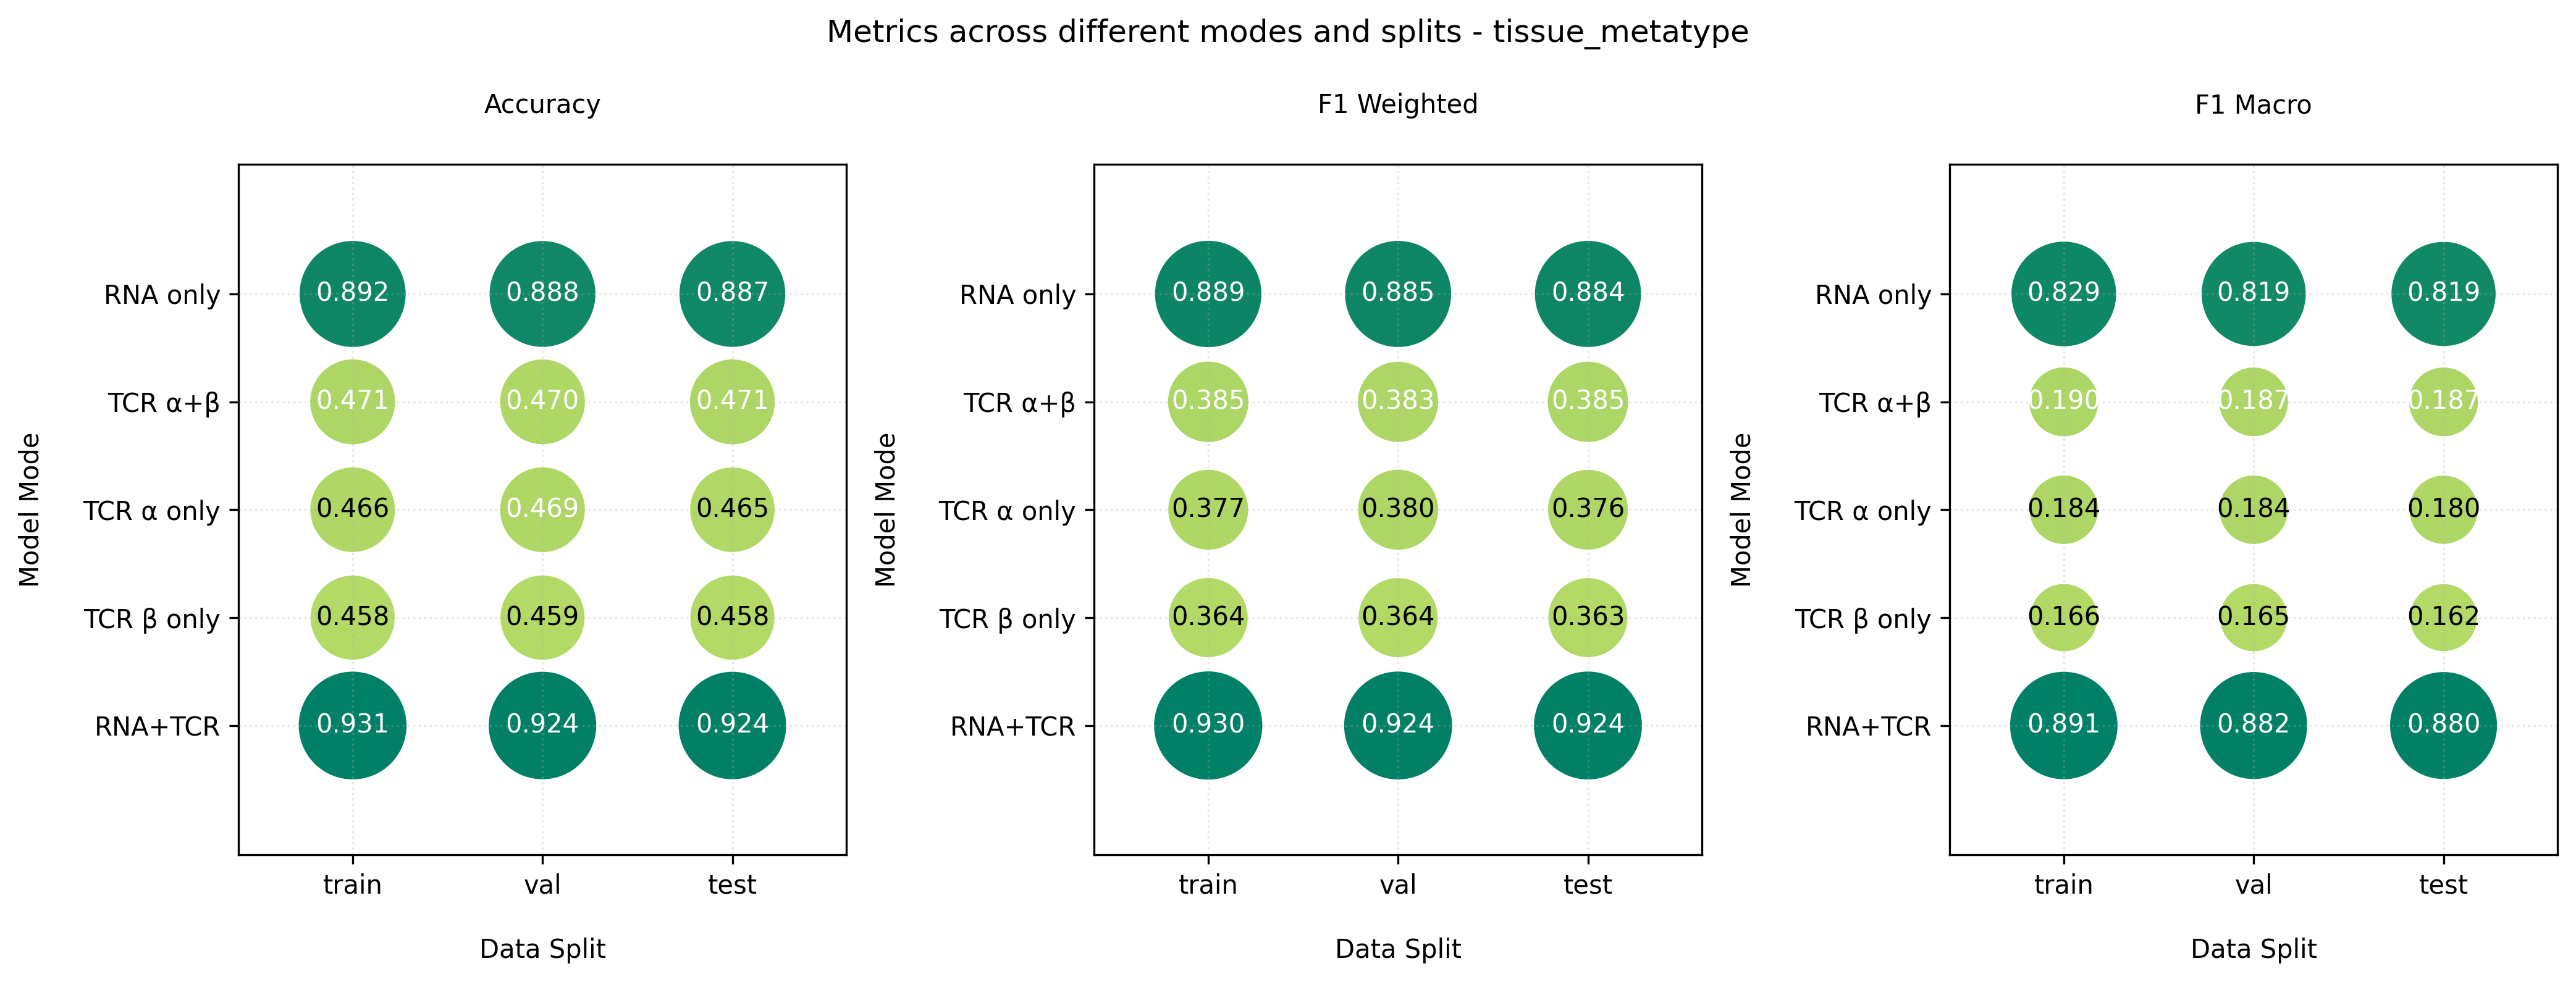

✓ Saved results and plots for Tissue Metatype


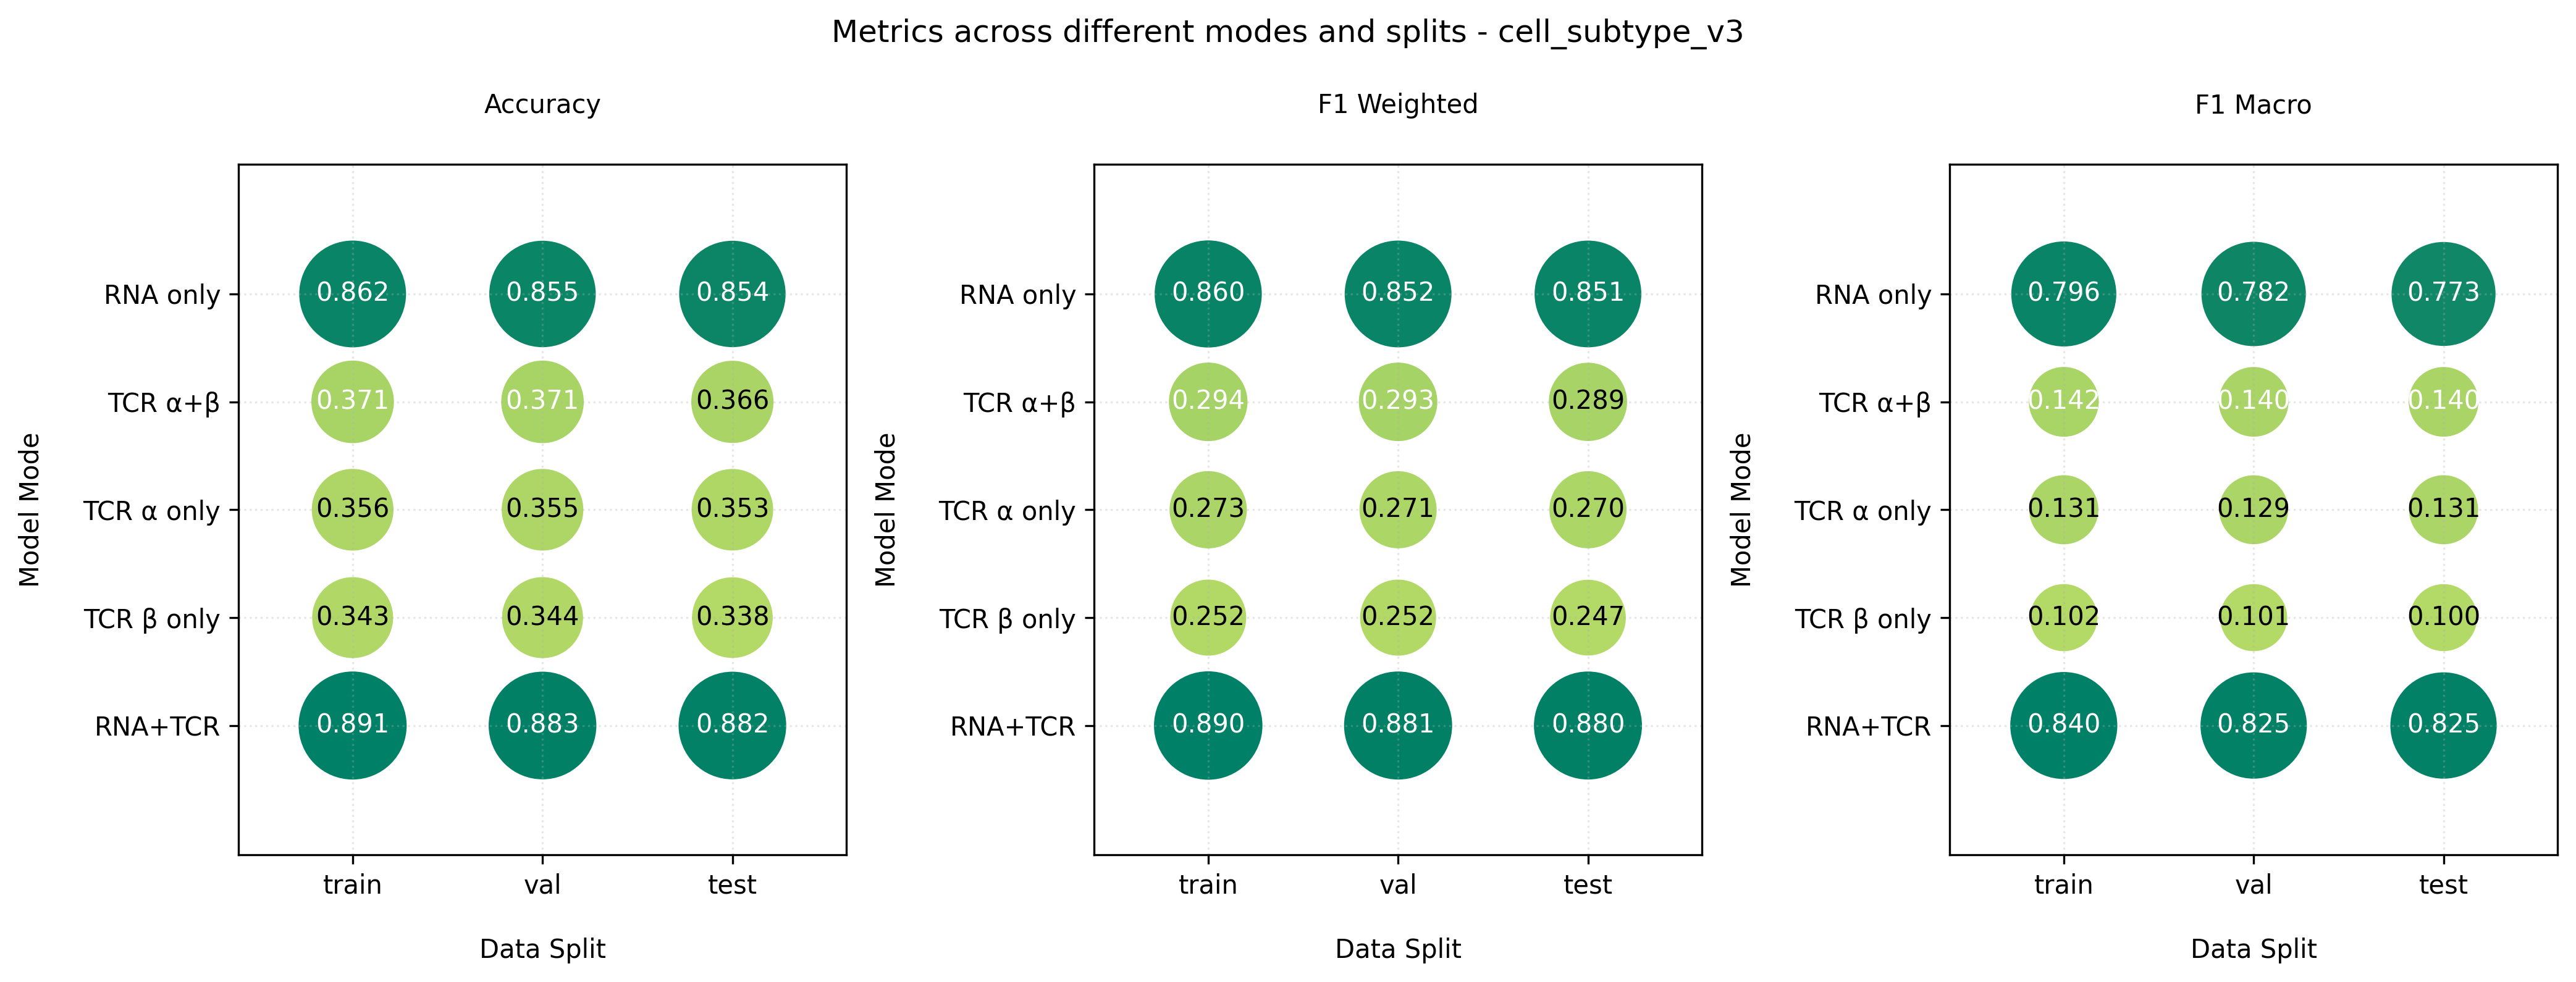

✓ Saved results and plots for cell_subtype_v3

All visualizations saved to: ../results/classification


In [16]:
# Build results dataframe and create visualizations
for task, task_results in results.items():
    task_name = task.lower().replace(' ', '_')
    
    # Build dataframe
    df = build_results_dataframe(task_results)
    
    # Save to CSV
    df.to_csv(f"{results_dir}/{task_name}_results.csv", index=False)
    
    # Create visualization
    plot_all_metrics_bubble_chart(df, results_dir, task_name)
    
    print(f"✓ Saved results and plots for {task}")

print("\nAll visualizations saved to:", results_dir)

## Summary

We successfully fine-tuned TCRfoundation for three classification tasks:
1. Disease classification
2. Tissue classification  
3. Cell subtype classification

The trained models and embeddings can now be used for:
- Downstream analysis
- Visualization (UMAP, etc.)
- Transfer learning to related tasks

Next: See Tutorial 3 for antigen specificity prediction!